In [1]:
import pandas as pd
from pathlib import Path
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
split = 'dev'
csv_file = f'/home/xu/Downloads/object_cxr/{split}.csv'
image_root = Path(f'/home/xu/Downloads/object_cxr/{split}')
labels = pd.read_csv(csv_file, na_filter=False)

In [3]:
OBJECT_SEP = ';'
ANNOTATION_SEP = ' '
def draw_annotation(im, anno_str, fill=(255, 63, 63, 40)):
    draw = ImageDraw.Draw(im, mode="RGBA")
    for anno in anno_str.split(OBJECT_SEP):
        anno = list(map(int, anno.split(ANNOTATION_SEP)))
        if anno[0] == 0:
            draw.rectangle(anno[1:], fill=fill)
        elif anno[0] == 1:
            draw.ellipse(anno[1:], fill=fill)
        else:
            draw.polygon(anno[1:], fill=fill)

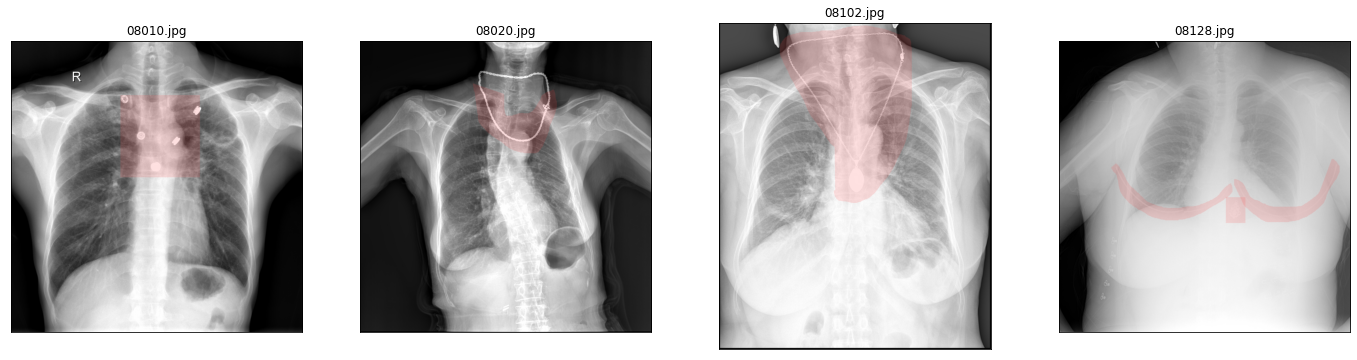

In [4]:
# viz
fig, axs = plt.subplots(
    nrows=1, ncols=4, subplot_kw=dict(xticks=[], yticks=[]), figsize=(24, 6)
)

example_idxes = [9, 19, 101, 127]
for row, ax in zip(
    labels.iloc[example_idxes].itertuples(index=False), axs
):
    im = Image.open(image_root / row.image_name).convert("RGB")
    if row.annotation:
        draw_annotation(im, row.annotation)
    
    ax.imshow(im)
    ax.set_title(f"{row.image_name}")

In [5]:
from shapely.geometry import LineString
from shapely.algorithms.polylabel import polylabel
from shapely.ops import unary_union

def polylabel_box(anno):
    polygon = anno.split(ANNOTATION_SEP)[1:]
    polygon = list(map(int, polygon))
    
    p = LineString(np.asarray(polygon + polygon[:2]).reshape(-1, 2))
    c = polylabel(p.buffer(100), tolerance=10)
    box = np.asarray(p.bounds).reshape(-1, 2)
    cxy = np.asarray(c)
    wh = np.abs(box - cxy)
    wh = np.maximum(wh[0], wh[1])
    box = [cxy - wh, wh * 2] # xmin, ymin, w, h
    #unary_union([p, c, LineString(box)])
    return list(np.asarray(box).flat)

def rectangle_box(anno):
    x = []
    y = []

    anno = anno[2:]
    anno = anno.split(ANNOTATION_SEP)
    for i in range(len(anno)):
        if i % 2 == 0:
            x.append(int(anno[i]))
        else:
            y.append(int(anno[i]))

    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)
    w = xmax - xmin
    h = ymax - ymin
    box = [xmin, ymin, w, h]
    return box

def annotation_to_bbox(annotation):
    bbox = []
    
    if not annotation:
        return bbox
    
    annotation_list = annotation.split(OBJECT_SEP)
    for anno in annotation_list:
        if anno[0] in ('0', '1'):
            box = rectangle_box(anno)
        elif anno[0] == '2':
            box = polylabel_box(anno)
        else:
            raise RuntimeError(anno[0])
        bbox.append(box)
    return bbox

In [6]:
image_id = 127
row = labels.iloc[image_id]
bbox = annotation_to_bbox(row.annotation)
bbox = np.asarray(bbox)

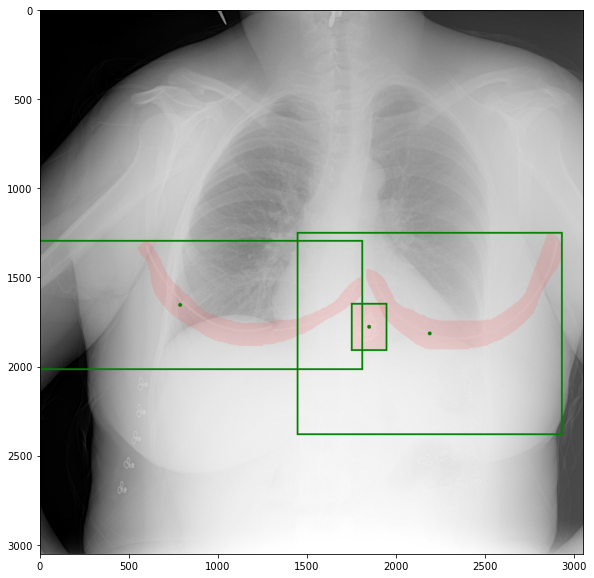

In [7]:
im = Image.open(image_root / row.image_name).convert("RGB")
draw_annotation(im, row.annotation)
draw = ImageDraw.Draw(im, mode="RGBA")
for box in bbox:
    draw.rectangle([box[0], box[1], box[0]+box[2], box[1]+box[3]], outline='green', width=10)
    cx, cy = box[0]+box[2]*0.5, box[1]+box[3]*0.5
    draw.ellipse((cx-10, cy-10, cx+10, cy+10), fill='green', outline ='green')
plt.figure(figsize=(10,10))
plt.imshow(im)
plt.show()

In [8]:
#labels_t = labels.loc[labels['annotation'].astype(bool)].reset_index(drop=True)
#labels_f = labels.loc[(1-labels['annotation'].astype(bool)).astype(bool)].reset_index(drop=True)

In [9]:
def annotation_to_coco(image_id, annotation):
    coco_anno = []
    
    for box in annotation_to_bbox(annotation):
        w = box[2]
        h = box[3]
        area = w * h
        coco_anno.append(dict(image_id=image_id, bbox=box, area=area, category_id=1, iscrowd=0))
    return coco_anno

In [10]:
images = []
annotations = []
for idx, row in labels.iterrows():
    image_name = row['image_name']
    annotation = row['annotation']
    img = Image.open(image_root / image_name)
    image = {'id': image_name, 'file_name': image_name, 'width': img.width, 'height': img.height}
    coco_anno = annotation_to_coco(image_name, annotation)
    images.append(image)
    annotations += coco_anno

In [11]:
len(images), len(annotations)

(1000, 1015)

In [12]:
for i, anno in enumerate(annotations):
    anno['id'] = i

In [13]:
coco_json = dict(images=images, annotations=annotations, categories=[{'id': 1, 'name': 'object'}])

In [14]:
with image_root.with_suffix('.json').open('w') as f:
    json.dump(coco_json, f)